# GEQIE IBMQ execution example

## Setup

In [ ]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots

import plotly.graph_objects as go

import plotly.express as px
import plotly.io as pio


pio.templates["latex"] = pio.templates["plotly_white"].update(
    layout=dict(
        colorway=px.colors.qualitative.D3,
        font=dict(
            family="CMU Serif",
            size=24
        )
    )
)

pio.templates.default = "latex"

from PIL import Image, ImageOps
from scipy.stats import pearsonr

In [2]:
import geqie
from geqie.encodings import frqi

In [3]:
CREDENTIALS_NAME = os.environ.get("CREDENTIALS_NAME")

API_TOKEN = os.environ.get("IQP_API_TOKEN")
INSTANCE_CRN = os.environ.get("IQP_INSTANCE_CRN")

In [5]:
IMAGE_PATH = Path("../assets/test_images/grayscale/test_image_4x4.png")

In [6]:
image = Image.open(IMAGE_PATH)
image = ImageOps.grayscale(image)
image = np.asarray(image)
image

array([[255,   0, 255, 127],
       [255,   0,   0, 255],
       [195, 255, 255, 255],
       [255, 195,   0, 255]], dtype=uint8)

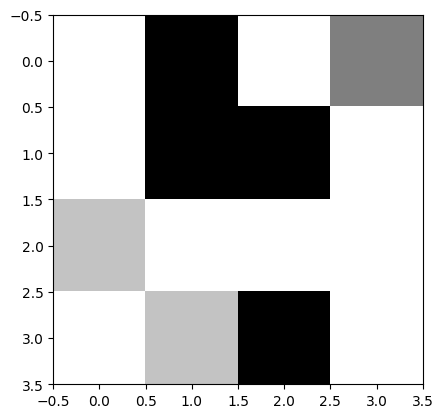

In [7]:
plt.imshow(image, cmap="gray")

## GEQIE Encoding

In [8]:
circuit = geqie.encode(frqi.init_function, frqi.data_function, frqi.map_function, image)
circuit.draw(output='text')

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
   q_4: »
        »
meas: 5/»
        »
«        ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                                                             ├»
«        │                                                                                                                              │»
«   q_1: ┤1                                                                                                                             ├»
«        │                                                                                                                              │»
«   q_2: ┤2 Initialize(0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0) ├»
«        │                                                                                                                              │»
«   q_3: ┤3                                                                                                                             ├»
«        │                                                                                                                              │»
«   q_4: ┤4                                                                                                                             ├»
«        └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«meas: 5/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                        »
«        ┌──────────┐ ░ ┌─┐            
«   q_0: ┤0         ├─░─┤M├────────────
«        │          │ ░ └╥┘┌─┐         
«   q_1: ┤1         ├─░──╫─┤M├─────────
«        │          │ ░  ║ └╥┘┌─┐      
«   q_2: ┤2 Unitary ├─░──╫──╫─┤M├──────
«        │          │ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤3         ├─░──╫──╫──╫─┤M├───
«        │          │ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤4         ├─░──╫──╫──╫──╫─┤M├
«        └──────────┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/════════════════╩══╩══╩══╩══╩═
«                        0  1  2  3  4

## IBM Quantum Platform Execution

In [9]:
result = geqie.execute(
    circuit=circuit,
    n_shots=1024,
    api_token=API_TOKEN,
    instance_crn=INSTANCE_CRN,
    return_qiskit_result=True,
    transpiler_args={
        "optimization_level": 3,
    },
    verbosity_level=geqie.logging.levels.DEBUG,
    # dry_run=True,
)

INFO	 2025-12-29 15:09:14 --- Setting up IBM Quantum backend... (geqie.main:120)
INFO	 2025-12-29 15:09:25 --- Circuit transpilation... (geqie.main:136)
INFO	 2025-12-29 15:09:26 --- Circuit transpilation. Done. (geqie.main:138)
INFO	 2025-12-29 15:09:28 --- Submitting job to backend 'ibm_fez'... (geqie.main:147)
DEBUG	 2025-12-29 15:09:29 --- job.job_id()='d598n67p3tbc73artit0' (geqie.main:149)
INFO	 2025-12-29 15:09:34 --- Job completed. (geqie.main:152)
DEBUG	 2025-12-29 15:09:34 --- job.metrics()={'timestamps': {'created': '2025-12-29T14:09:28.551609Z', 'finished': '2025-12-29T14:09:33.188027Z', 'running': '2025-12-29T14:09:29.568267Z'}, 'bss': {'seconds': 2}, 'usage': {'quantum_seconds': 2, 'seconds': 2}, 'qiskit_version': 'qiskit_ibm_runtime-0.44.0,qiskit-1.4.5*,qiskit_aer-0.17.2*', 'caller': 'qiskit_ibm_runtime~sampler.py'} (geqie.main:153)


In [10]:
counts = result[0].data.meas.get_counts()

# Sort by integer value of bitstring
states = sorted(counts.keys(), key=lambda x: int(x, 2))
values = [counts[s] for s in states]

Text(0, 0.5, 'n_results')

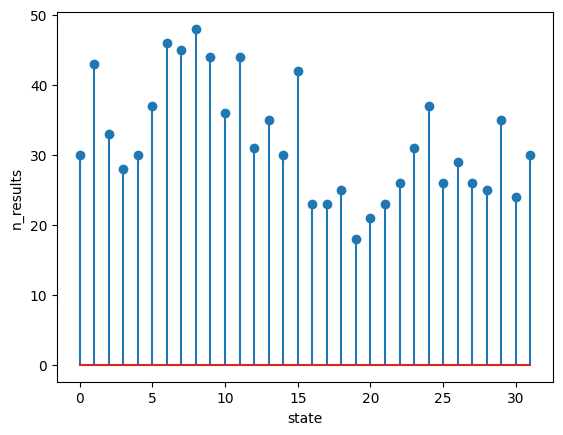

In [11]:
plt.stem(values)
plt.xlabel("state")
plt.ylabel("n_results")

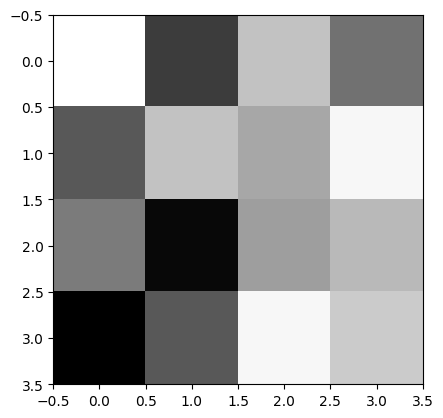

In [12]:
retrieved_image = frqi.retrieve_function(counts)
plt.imshow(retrieved_image, cmap="gray")
plt.show()

### Reconstructed image

In [13]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("original", "reconstructed"))

fig.add_trace(go.Image(z=image), row=1, col=1)
fig.add_trace(go.Image(z=retrieved_image), row=1, col=2)

fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(height=400, width=800, margin=dict(t=50))

fig.show()

In [14]:
pcc, p_value = pearsonr(image.flatten(), retrieved_image.flatten())
print(f"{pcc=:.3f}, {p_value=:.3e}")

pcc=-0.098, p_value=7.189e-01
